**IMPORT THƯ VIỆN**

In [0]:
%tensorflow_version 1.x
from keras.utils import to_categorical
import tensorflow as tf
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import*
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import tensorflow_hub as tfHub
from tensorflow.keras import layers as tfLayers
from keras import models
from keras.models import Model
from keras import layers

Using TensorFlow backend.


**DOWLOAD DỮ LIỆU**

In [0]:
!pip install kaggle

In [0]:
! mkdir ~/.kaggle

In [0]:
!cp './kaggle.json' '/root/.kaggle/'

In [0]:
!kaggle datasets download --force -d 'zalando-research/fashionmnist'
!rm '/root/.kaggle/kaggle.json'

 95% 65.0M/68.8M [00:00<00:00, 61.3MB/s]
100% 68.8M/68.8M [00:00<00:00, 78.8MB/s]


In [0]:
!unzip 'fashionmnist.zip' -d 'my_data'

Archive:  fashionmnist.zip
  inflating: my_data/fashion-mnist_test.csv  
  inflating: my_data/fashion-mnist_train.csv  
  inflating: my_data/t10k-images-idx3-ubyte  
  inflating: my_data/t10k-labels-idx1-ubyte  
  inflating: my_data/train-images-idx3-ubyte  
  inflating: my_data/train-labels-idx1-ubyte  


In [0]:
train_dataset = pd.read_csv('./my_data/fashion-mnist_train.csv').values
test_dataset = pd.read_csv('./my_data/fashion-mnist_test.csv').values
train_data = pd.read_csv('./my_data/fashion-mnist_train.csv')
test_data = pd.read_csv('./my_data/fashion-mnist_test.csv')
num_train_examples = len(train_dataset)
num_test_examples = len(test_dataset)

In [0]:
train_dataset.shape,train_data.shape


((60000, 785), (60000, 785))

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']
num_classes = len(class_names)

In [0]:
print('num_train: ',num_train_examples)
print('num_test: ',num_test_examples)
print('num_class: ',num_classes)

num_train:  60000
num_test:  10000
num_class:  10


In [0]:
train_data.shape #(60,000*785)
test_data.shape #(10000,785)
train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0]) # (60000,)
test_Y = np.array(test_data.iloc[:,0]) #(10000,)

In [0]:
train_X.shape

(60000, 784)

In [0]:
# chuyển hình ảnh sang 3 kênh
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape


((60000, 784, 3), (10000, 784, 3))

In [0]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [0]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [0]:

train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [0]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 32

In [0]:
train_X.shape

(60000, 48, 48, 3)

**FEATURE EXTRACTOR**

In [0]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [0]:
conv_base=tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)

print(train_features.shape, "\n",  test_features.shape, "\n")

10000/10000 [==============================] - 236s 24ms/sample
(60000, 1, 1, 512) 
 (10000, 1, 1, 512) 



In [0]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (60000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
#svm_train=train_features.reshape((60000, 1*1*512))
svm_train=train_features_flat
svm_y=train_Y

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC())
model=clf.fit(svm_train, svm_y)

In [0]:
from sklearn.metrics import classification_report
preds = clf.predict(test_features_flat)
print(classification_report(test_Y, preds))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.99      0.98      0.98      1000
           2       0.81      0.81      0.81      1000
           3       0.85      0.89      0.87      1000
           4       0.78      0.83      0.80      1000
           5       0.96      0.95      0.96      1000
           6       0.69      0.59      0.64      1000
           7       0.92      0.94      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



**Fine tuning** 

1) Chuyển đổi hình ảnh với 1 kênh thành 3 kênh

2) Thay đổi kích thước hình ảnh

3) Sử dụng mô hình cơ sở VGG16, nối thêm các lớp khác và trích xuất các tính năng



In [0]:
Xtrain,valid_X,ytrain,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [0]:
aug_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
aug_val = ImageDataGenerator(rescale=1./255)
aug_test = ImageDataGenerator(rescale=1./255)



In [0]:
base_model=tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

for layer in base_model.layers:
    layer.trainable = False


In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [0]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import RMSprop, SGD

last_layer = base_model.get_layer('block5_pool')
x=last_layer.output
x=layers.Flatten()(x)
x= layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

model_3 = models.Model(inputs=base_model.input, outputs=x)
model_3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history= model_3.fit_generator(aug_train.flow(Xtrain,ytrain, batch_size=32), 
                               validation_data=(aug_val.flow(valid_X, valid_label,batch_size=32)),epochs=25,verbose=1)
                            
              
              
#history = model_3.fit(train_X, train_label, batch_size=32, epochs=25,validation_data=(valid_X, valid_label))

Epoch 1/25
1500/1500 [==============================] - 110s 73ms/step - loss: 1.0010 - acc: 0.6414 - val_loss: 0.6428 - val_acc: 0.7651
Epoch 2/25
1500/1500 [==============================] - 109s 73ms/step - loss: 0.8676 - acc: 0.6861 - val_loss: 0.6434 - val_acc: 0.7606
Epoch 3/25
1500/1500 [==============================] - 110s 73ms/step - loss: 0.8244 - acc: 0.6996 - val_loss: 0.6082 - val_acc: 0.7823
Epoch 4/25
1500/1500 [==============================] - 109s 72ms/step - loss: 0.8002 - acc: 0.7088 - val_loss: 0.5756 - val_acc: 0.7954
Epoch 5/25
1500/1500 [==============================] - 109s 72ms/step - loss: 0.7817 - acc: 0.7166 - val_loss: 0.5820 - val_acc: 0.7886
Epoch 6/25
1500/1500 [==============================] - 109s 73ms/step - loss: 0.7741 - acc: 0.7163 - val_loss: 0.5791 - val_acc: 0.7942
Epoch 7/25
1500/1500 [==============================] - 109s 72ms/step - loss: 0.7641 - acc: 0.7214 - val_loss: 0.5655 - val_acc: 0.7958
Epoch 8/25
1500/1500 [===================

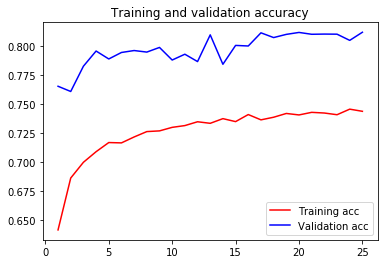

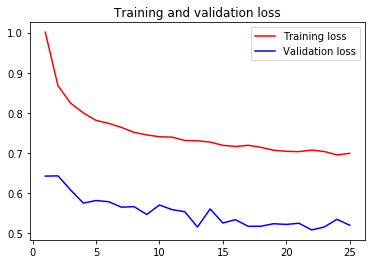

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [0]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

In [0]:
from sklearn.metrics import classification_report
preds = model_3.predict(test_X)
print(classification_report(np.argmax(test_Y_one_hot, axis=1), np.argmax(preds, axis=1)))
                            
                      

              precision    recall  f1-score   support

           0       0.43      0.80      0.56      1000
           1       0.98      0.84      0.91      1000
           2       0.51      0.76      0.61      1000
           3       0.49      0.70      0.58      1000
           4       0.54      0.52      0.53      1000
           5       0.57      0.18      0.28      1000
           6       0.15      0.17      0.16      1000
           7       0.91      0.10      0.17      1000
           8       0.63      0.65      0.64      1000
           9       0.82      0.68      0.75      1000

    accuracy                           0.54     10000
   macro avg       0.60      0.54      0.52     10000
weighted avg       0.60      0.54      0.52     10000



Run the following cell to terminate the kernel and free memory resources:



In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)